In [1]:
%load_ext autoreload
%autoreload 2
from readers.base import NeuralynxReader
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
import pandas as pd

In [2]:
rootdir = '/media/sil2/Data/Lizard/lorenz_data/2019-11-17_17-43-33'
rd = NeuralynxReader(rootdir, channel=32)

CPU times: user 1.35 s, sys: 1 s, total: 2.36 s
Wall time: 3.24 s


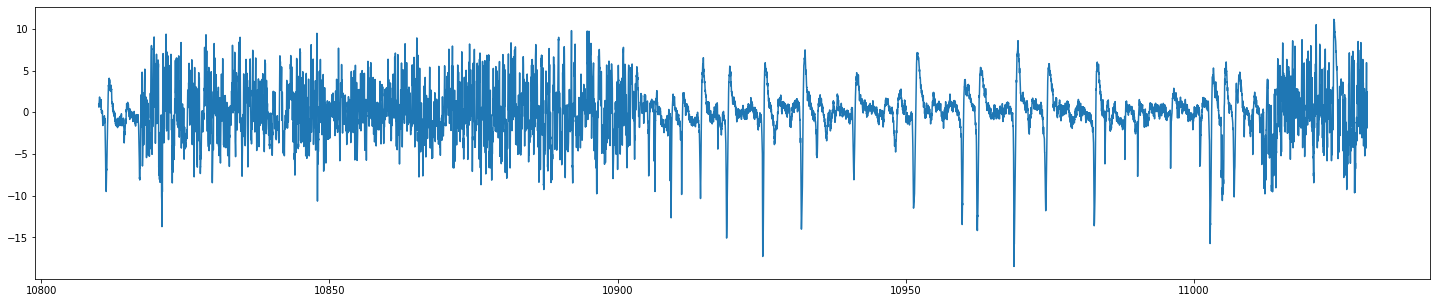

In [3]:
%%time
v, t = rd.read(i_start=int((3*3600)*rd.fs), i_stop=int((3.5*3600)*rd.fs), lowpass=20, filter_order=3)
v, t = v[int(10*rd.fs):int(230*rd.fs)], t[int(10*rd.fs):int(230*rd.fs)]
plt.figure(figsize=(25, 5))
plt.plot(t, v)

In [138]:
from numba import cuda

all_gpu_devices = [device.id for device in cuda.list_devices()]  # Get a list of all available GPU devices
all_gpu_devices

[0]

In [ ]:
%%time
import stumpy
from dask.distributed import Client

dask_client = Client()
window = int(rd.fs * 1.2)
mps = {}  # Store the 1-dimensional matrix profiles
motifs_idx = {}  # Store the index locations for each pair of 1-dimensional motifs (i.e., the index location of two smallest matrix profile values within each dimension)

mps = stumpy.stumped(dask_client, v, m=window)
motif_distance = np.round(mps[:, 0].min(), 1)
motifs_idx = np.argsort(mps[:, 0])[:2]
print(f"The motif pair matrix profile value is {motif_distance}")

In [149]:
!pip install "dask[complete]" --upgrade

In [137]:
fig, axs = plt.subplots(len(mps), sharex=True, gridspec_kw={'hspace': 0})
for i, dim_name in enumerate(list(mps.keys())):
    axs[i].set_ylabel(dim_name, fontsize='20')
    axs[i].plot(v)
    axs[i].set_xlabel('Time', fontsize ='20')
    for idx in motifs_idx[dim_name]:
        axs[i].plot(v[idx:idx+window], c='red', linewidth=4)
        axs[i].axvline(x=idx, linestyle="dashed", c='black')
plt.show()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 432x288 with 0 Axes>

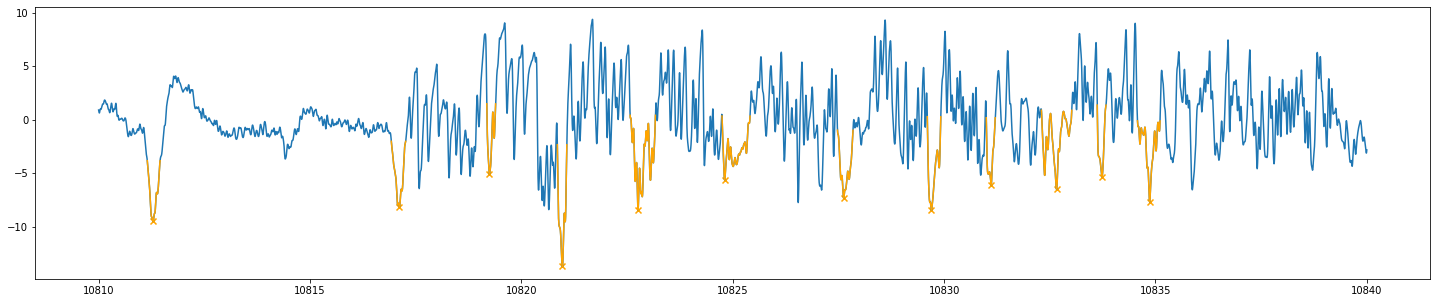

In [132]:
plt.figure(figsize=(25, 5))
[peaks, properties] = find_peaks(-v, height=5, width=rd.fs*0.2, prominence=8, distance=rd.fs*0.5)
plt.plot(t, v)
plt.scatter(t[peaks], v[peaks], c='orange', marker='x')
for i in range(len(peaks)):
  i_start = int(properties['left_ips'][i])
  i_stop = int(properties['right_ips'][i])
  plt.plot(t[i_start:i_stop], v[i_start:i_stop], color='orange')

In [97]:
properties

{'peak_heights': array([10.30356572,  8.82483425,  5.41025861, 13.64491711,  7.37123884,
         5.64385374,  7.52162256,  9.01252024,  5.8966263 ,  6.37985704,
         5.29580461,  7.30088199,  4.95694622]),
 'prominences': array([12.16607381, 13.16197094, 13.88049844, 23.31726319, 15.97864247,
        11.30569974, 16.61940486, 17.37350314, 11.6110337 , 13.68783944,
        13.47142517, 13.835345  , 10.74694662]),
 'left_bases': array([  4792,  57713, 292240, 306773, 373175, 456334, 373175, 373175,
        640307, 640307, 742708, 742708, 854414]),
 'right_bases': array([306773, 306773, 306773, 373175, 456334, 516691, 595114, 742708,
        688228, 742708, 784627, 854414, 922775]),
 'widths': array([10033.6310223 , 10781.52067683,  6578.97184553, 22305.66278056,
        19437.93868186, 34422.21228051, 24141.29957433, 10311.00853772,
        14076.16297062, 16548.45201737,  6436.63866706, 16154.15728427,
         8463.38388629]),
 'width_heights': array([ 4.22052882,  2.24384878, -1.

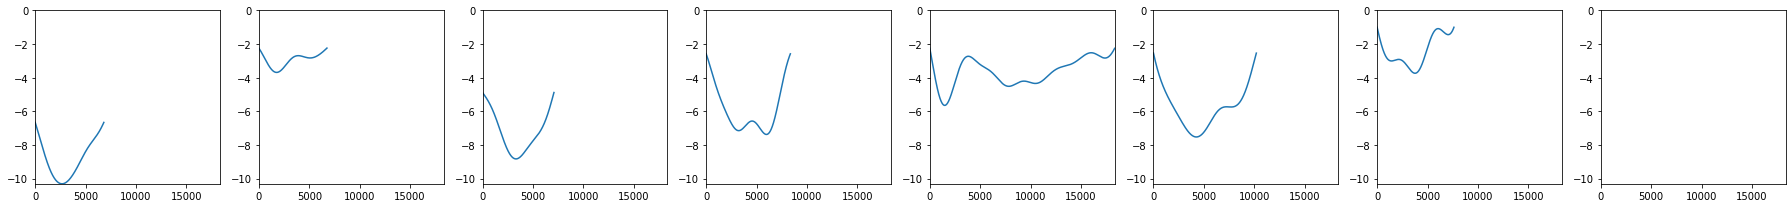

In [61]:
def plot_peaks(cols=8):
  rows = int(np.ceil(len(peaks)/cols))
  fig, axes = plt.subplots(rows, cols, figsize=(25, 3*rows))
  axes = axes.flatten()
  xmax, xmin, ymax, ymin = 0, 0, 0, 0
  for i, peak in enumerate(peaks):
      v_ = v[int(properties['left_ips'][i]):int(properties['right_ips'][i])]
      x_ = np.arange(0, len(v_))
      axes[i].plot(x_, v_)
      if min(v_) < ymin: ymin = min(v_)
      if min(x_) < xmin: xmin = min(x_)
      if max(v_) > ymax: ymax = max(v_)
      if max(x_) > xmax: xmax = max(x_)
  for ax in axes:
      ax.set_xlim([xmin, xmax])
      ax.set_ylim([ymin, ymax])
  fig.tight_layout()

plot_peaks()

In [18]:
for k, v in rd.reader.header.items():
  print(k, v)

nb_block 1
nb_segment [1]
signal_streams [('signals', '0')]
signal_channels [('CSC1', '19', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC10', '14', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC11', '2', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC12', '13', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC13', '3', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC14', '12', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC15', '5', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC16', '10', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC17', '6', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC18', '9', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC19', '7', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC2', '28', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC20', '8', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC21', '18', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC22', '29', 32000., 'int16', 'uV', 0.01525926, 0., '0')
 ('CSC23', '17', 3

In [69]:
rd.fs

32000.0

In [74]:
t = np.arange(rd.reader.segment_t_start(block_index=0, seg_index=0),
              rd.reader.segment_t_stop(block_index=0, seg_index=0), 1/rd.fs)
t.shape

(1786635777,)

In [80]:
x = np.array([1,2,3])
x[2:None]

array([3])

In [67]:
ev_timestamps, ev_durations, ev_labels = rd.reader.get_event_timestamps(block_index=0, seg_index=0, event_channel_index=0,
                                                                        t_start=None, t_stop=None)
ev_timestamps = rd.reader.rescale_event_timestamp(ev_timestamps, dtype='float64', event_channel_index=0)

In [68]:
ev_timestamps[-1]

55832.36300000176

In [64]:
raw_sigs = rd.reader.get_analogsignal_chunk(block_index=0, seg_index=0, i_start=0, i_stop=10000,
                                                      channel_names=[f'CSC32'])

In [65]:
raw_sigs

array([[-276],
       [-204],
       [-176],
       ...,
       [-363],
       [-405],
       [-391]], dtype=int16)